# Notebook for clustering SalishSeaCast data - PRODIGY Field School May 2024

### Written by Ilias Bougoudis with edits by Susan Allen

## Learning Goals

After complete this exercise students will be able to:

* use a simple package to cluster ocean fields
* describe the spatial variability and similarity in our region

### We will use the sklearn-som package. In order to install it, follow one of the steps below:
1) Use the provided py311_prodigy environment
2) Run on your terminal > pip install sklearn-som

## What is clustering?

### From this
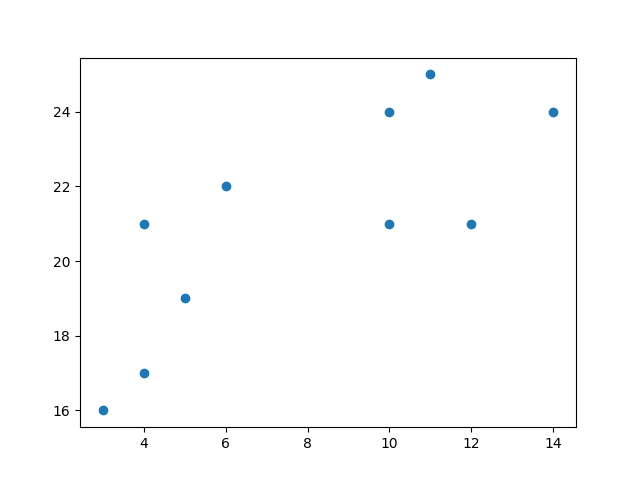

### To this
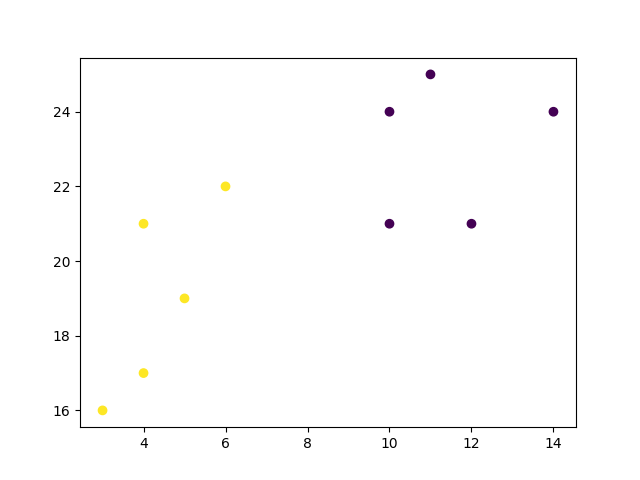

## Importing

In [ ]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn_som.som import SOM
import xarray as xr

In [ ]:
# color maps, including masking land as grey
cm_haline = copy.copy(cm.haline)
cm_haline.set_bad('grey')
cm_balance = copy.copy(cm.balance)
cm_balance.set_bad('grey')
cm_matter = copy.copy(cm.matter)
cm_matter.set_bad('grey')
cm_rain = copy.copy(cm.rain)
cm_rain.set_bad('grey')
cmap_tab = plt.get_cmap('tab20')
cmap_tab.set_bad('grey')
cmap_viridis = plt.get_cmap('viridis')
cmap_viridis.set_bad('grey')

In [ ]:
# ratio to make plots square (size of gridY versus a gridX cell)
aspect = 500/440
adjustable = 'box'

## Results Reading

In [ ]:
# point to the ERDDAP server and the specific data sets we will use
server = "https://salishsea.eos.ubc.ca/erddap"
protocol = 'griddap'
dataset_ids = { "grid": "ubcSSn3DMeshMaskV21-08",
    "physics": "ubcSSg3DPhysicsFields1hV21-11",
    "biology" : "ubcSSg3DBiologyFields1hV21-11",
    "turbulence" : "ubcSSg3DwGridFields1hV21-11"}
datelist = ['2024-05-11T20:30:00']

In [ ]:
# choose region of interest in model grid points
ygmin, ygmax = 700, 800
xgmin, xgmax = 110, 210
# region for profile
xcmin, xcmax = 120, 160
sy = 725
# indexes for depths
ksurface = 0  # 0.5 m except for turbulence, use 1 for 1.0 m
k6m = 6 # 6.5 m
k25m = 20 # 24 m
k75m = 25 # 76.5 m

In [ ]:
# physics fields
full_URL = '/'.join([server,protocol,dataset_ids['physics']])
print(full_URL)
phys = xr.open_dataset(full_URL)

In [ ]:
# biology fields
full_URL = '/'.join([server,protocol,dataset_ids['biology']])
print(full_URL)
biol = xr.open_dataset(full_URL)

In [ ]:
# turbulence
full_URL = '/'.join([server,protocol,dataset_ids['turbulence']])
print(full_URL)
turb = xr.open_dataset(full_URL)

In [ ]:
# and our mask
full_URL = '/'.join([server,protocol,dataset_ids['grid']])
print(full_URL)
mesh = xr.open_dataset(full_URL)
tmask = mesh.tmask[0, :, ygmin:ygmax, xgmin:xgmax].values
mesh.close()

## Get three data sets

In [ ]:
# variable 1, my choice salinity at 25 m
sal = phys['salinity'].isel(  
                  gridX=slice(xgmin, xgmax),  
                  gridY=slice(ygmin, ygmax),).sel(
                  time=datelist,
                  depth=25, method='nearest',
                 )
sal.where(tmask[k25m]).plot(cmap=cm_haline);

In [ ]:
# variable 2, my choice nitrate at 25 m
nit = biol['nitrate'].isel(  
                  gridX=slice(xgmin, xgmax),  
                  gridY=slice(ygmin, ygmax),).sel(
                  time=datelist,
                  depth=25, method='nearest',
                 )
nit.where(tmask[k25m]).plot(cmap=cm_rain);

In [ ]:
# variable 3, my choice turbulent dissipation at 25 m
dissip = turb['dissipation'].isel(  
                  gridX=slice(xgmin, xgmax),  
                  gridY=slice(ygmin, ygmax),).sel(
                  time=datelist,
                  depth=25, method='nearest',
                 )
dissip.where(tmask[k25m]).plot(cmap=cm_matter);

## Clustering - single variable

In [ ]:
def clustering_single(inputs, m, n):

    inputs0 = inputs # We need the dimensions of the original inputs variable    

    # Pre processing 

    # Making the variable flat
    inputs = np.ravel(inputs)   

    # Finding nans
    indx = np.where(~np.isnan(inputs))
    inputs2 = inputs[indx] # We need the original inputs variable

    inputs2 = inputs2.reshape(len(inputs2),1)

    # Normalization of the values
    inputs2 = (inputs2 - inputs2.min(axis=0)) / (inputs2.max(axis=0) - inputs2.min(axis=0))

    # SOM
    som = SOM(m, n, dim= inputs2[0].size) # m, n are the dimensions of the produced map, dim is the amount of features (variables) of the inputs
    predictions = som.fit_predict(inputs2) # Training 

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs.size, np.nan) # We need the shape of the original inputs variable
    indx2[indx] = predictions
    clusters = np.reshape(indx2, (len(inputs0.gridY), len(inputs0.gridX)))

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
        coords = {'gridY': inputs0.gridY, 'gridX': inputs0.gridX},
        dims = ['gridY', 'gridX'],
        attrs = dict(description="Clusters of the performed self organizing map algorithm",
        long_name = "Cluster",
        units = "counts"))
    
    return (clusters, unique, counts)

## Clustering - multiple variables

In [ ]:
def clustering_multiple(inputs, m, n):

    inputs0 = inputs # We need the dimensions of the original inputs variable    
    inputs = inputs.to_numpy()

    # Pre processing 

    # Making the variables flat
    inputs = np.reshape(inputs,(inputs.shape[0], inputs.shape[1] * inputs.shape[2])) 

    # Finding nans
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]] # We need the original inputs variable

    inputs2 = inputs2.transpose()

    # Normalization of the values
    inputs2 = (inputs2 - inputs2.min(axis=0)) / (inputs2.max(axis=0) - inputs2.min(axis=0))

    # SOM
    som = SOM(m, n, dim= inputs2[0,:].size) # m, n are the dimensions of the produced map, dim is the amount of features (variables) of the inputs
    predictions = som.fit_predict(inputs2) # Training 

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan) # We need the shape of the original inputs variable
    indx2[indx[0]] = predictions
    clusters = np.reshape(indx2,(inputs0.shape[1],inputs0.shape[2]))

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
        coords = {'y': np.arange(0,inputs0.shape[1]), 'x': np.arange(0,inputs0.shape[2])},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed self organizing map algorithm",
        long_name ="Cluster",
        units="counts"))
    
    return (clusters, unique, counts)


## Plotting - single variable

In [ ]:
def plotting_single(clusters, inputs, unique):

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4.5))
    
    no_unique = unique.max() + 1
    
    clus = clusters.plot(ax=axs[0], colors=cmap_tab.colors[:no_unique], 
                         levels=range(no_unique+1), add_colorbar=False)
   
    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')

    inputs.plot(ax=axs[1], cmap=cmap_viridis)

    for ax in axs:
        ax.set_aspect(aspect, adjustable=adjustable)
        ax.title.set_text('')
        ax.set_facecolor('grey')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout();

## Plotting - multiple variables

In [ ]:
def plotting_multiple(clusters, inputs, unique):

    fig, axs = plt.subplots(2, 2, figsize=(10, 9))

    no_unique = unique.max() + 1

    clus = clusters.plot(ax=axs[0,0], colors=cmap_tab.colors[:no_unique],
                         levels=range(no_unique+1), add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')

    inputs[0].plot(ax=axs[0, 1], cmap=cmap_viridis)
    inputs[1].plot(ax=axs[1, 0], cmap=cmap_viridis)
    inputs[2].plot(ax=axs[1, 1], cmap=cmap_viridis)

    for ax in axs.flatten():
        ax.set_aspect(aspect, adjustable=adjustable)
        ax.title.set_text('')
        ax.set_facecolor('grey')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout();


## Printing

In [ ]:
def printing(unique, counts):
    for i in  range(0, len(unique)):        
        print(f'The amount of grid boxes for cluster {unique[i]+1} is {counts[i]}')

## Clustering with one variable as input

In [ ]:
no_clusters = 5

# Defining the inputs
inputs = sal.where(tmask[20]) 

clusters, unique, counts = clustering_single(inputs, no_clusters, n=1)

printing(unique, counts)
plotting_single(clusters, inputs, unique)

##### Clustering with three variable as inputs

In [ ]:
no_clusters = 6

# Defining the inputs (here I take the log of the dissipation because that is more "Gaussian", other fields that might
# help by transforming are the Eddy Viscosity (use 1e-7), and the diatoms & flagellates (use 1e-3)
input1 = sal.where(tmask[20])
input2 = nit.where(tmask[20])
input3 = np.log10((dissip+1e-12).where(tmask[20]))

inputs = xr.concat([input1, input2, input3], dim='time') 

clusters, unique, counts = clustering_multiple(inputs, m, n=1)

printing(unique, counts)
plotting_multiple(clusters, [input1, input2, input3], unique)